# Variational Autoencoders

In [1]:
import pandas as pd 
import os,shutil
import random 
import matplotlib.pyplot as plt 
from PIL import Image
import pandas as pd 
import os , shutil
import torch 
import torchvision
import torch.nn.functional as F

from torchvision import transforms as T 
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import Linear,ReLU,Sequential,Dropout,Sigmoid,Tanh , Conv2d,LeakyReLU,BatchNorm2d,Flatten,ConvTranspose2d
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset
from tqdm import tqdm
import albumentations 
from albumentations.pytorch import ToTensorV2
import numpy as np

/home/billy/miniconda3/envs/py312/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# AUO-ENCODERS 

## ARCHITECTURE for HAND_WRITTEN DIGIT GENERATION

<img src="images/AE.png">

In [2]:
# Dataprep

transform = T.Compose([
    T.ToTensor()
])
train_set = torchvision.datasets.MNIST(root=".",
                                      train=True,download=True,transform=transform)
test_set = torchvision.datasets.MNIST(root=".",
                                      train=False,download=True,transform=transform)


In [3]:
batch_sz=32
train_loader = DataLoader(dataset=train_set,shuffle=True,batch_size=batch_sz)
test_loader = DataLoader(dataset=test_set,shuffle=True,batch_size=batch_sz)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
input_dim = 784
z_dim = 20
h_dim=200
class AE(nn.Module):
    def __init__(self,input_dim,z_dim,h_dim):
        super().__init__()
        self.common = Linear(input_dim,h_dim)
        self.encoded = Linear(h_dim,z_dim)
        self.L1 = Linear(z_dim,h_dim)
        self.decoded = Linear(h_dim,input_dim)

    def encode(self,x):
        return self.encoded(F.relu(self.common(x)))

    def decode(self,x):
        return torch.sigmoid(self.decoded(F.relu(self.L1(x))))

    def forward(self,x):
        mu= self.encode(x)
        out = self.decode(mu)
        return out , mu
    

In [5]:
model = AE(input_dim,z_dim,h_dim).to(device)
lr =0.00025
optim= torch.optim.Adam(model.parameters(),lr=lr)

In [6]:
# plot function 
## populate the list of original images 
ogs =[]
idx=0
for img,label in test_set:
    if label==idx:
        ogs.append(img)
        idx+=1
    if idx==10:
        break
## plot func adding generated data on fly 
def plot():
    recons=[]
    for idx in range(10):
        with torch.no_grad():
            img = ogs[idx].reshape((1,input_dim)).to(device)
            out,mu= model(img)
        recons.append(out)
    imgs = ogs+recons
    plt.figure(figsize=(10,3),dpi=100)
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        img = imgs[i].detach().cpu().numpy().reshape(28, 28)
        plt.imshow(img, cmap="binary")
        plt.xticks([])
        plt.yticks([])
        if i == 0:  
            plt.title("Original", fontsize=8, pad=10)
    
    # Plot reconstructed images 
    for i in range(10, 20):
        plt.subplot(2, 10, i + 1)
        img = imgs[i].detach().cpu().numpy().reshape(28, 28)
        plt.imshow(img, cmap="binary")
        plt.xticks([])
        plt.yticks([])
        if i == 10:  
            plt.title("Reconstructed", fontsize=8, pad=10)
        

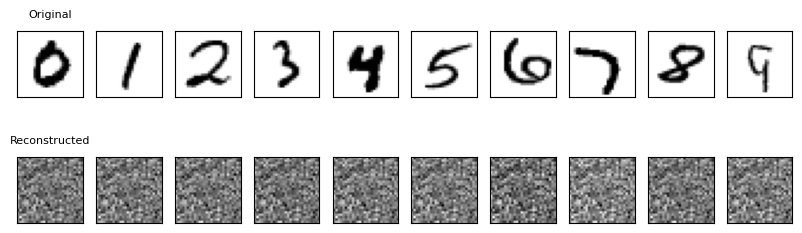

In [7]:
plot()

at epoch0, total loss =0.04028340711990992
at epoch1, total loss =0.018596974630653858
at epoch2, total loss =0.01511008711407582
Imagea at epoch: 2
at epoch3, total loss =0.013747405418753625
at epoch4, total loss =0.012859824964404106
at epoch5, total loss =0.012213703725238641
Imagea at epoch: 5
at epoch6, total loss =0.011709043481449286
at epoch7, total loss =0.01130405979057153
at epoch8, total loss =0.010967773544291655
Imagea at epoch: 8
at epoch9, total loss =0.010683581431458394
at epoch10, total loss =0.010437940276910862
at epoch11, total loss =0.01023012532889843
Imagea at epoch: 11


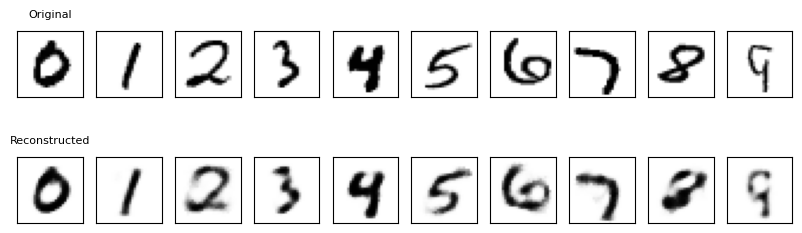

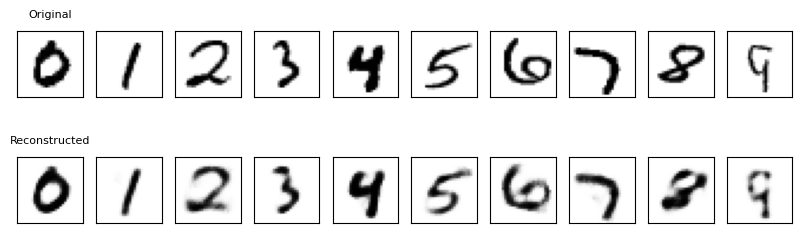

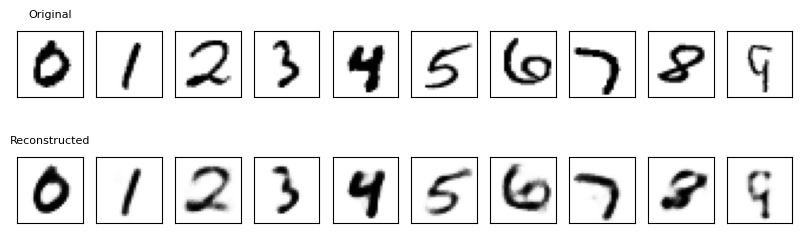

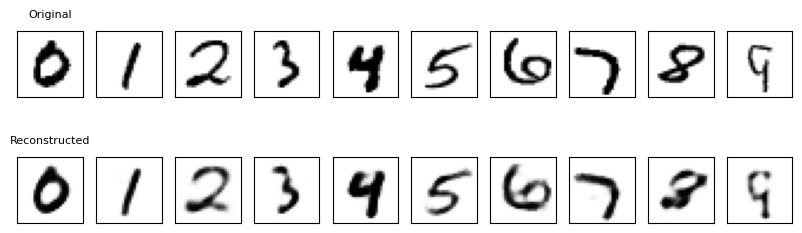

In [8]:
for epoch in range(12):
    tloss =0
    for imgs,labels in train_loader:
        imgs = imgs.to(device).view(-1,input_dim)
        out , mu = model(imgs)
        loss = ((out-imgs)**2).mean()
        optim.zero_grad()
        loss.backward()
        optim.step()
        tloss+=loss.item()
    print(f"at epoch{epoch}, total loss ={tloss/len(train_loader)}")
    if (1+epoch)%3==0:
        print(f"Imagea at epoch: {epoch}")
        plot()
    

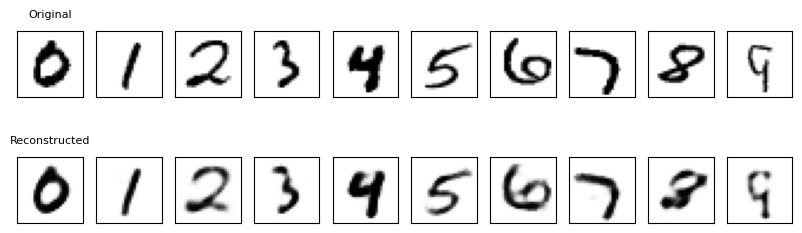

In [9]:
# saving the model 
scripted = torch.jit.script(model)
scripted.save('files/AE_digits.pt')
plot()

# BLUEPRINT OF VAE

<img src="images/VAE.png">

In [46]:
transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
])

In [47]:
transform = T.Compose([
    T.Resize((256)),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

data_set = ImageFolder(root=r'files/glass_data',
                      transform=transform)
batch_sz=32
loader=DataLoader(dataset=data_set,batch_size=batch_sz,shuffle=True,pin_memory=True)

In [48]:
# encoder class 
latent_dims=100
class VAE_Encoder(nn.Module):
    def __init__(self,latent_dims=100):
        super().__init__()
        self.con1 = Conv2d(3,8,3,stride=2,padding=1)
        self.con2 = Conv2d(8,16,3,stride=2,padding=1)
        self.batch_n = nn.BatchNorm2d(16)
        self.con3 = Conv2d(16,32,3,stride=2,padding=0)
        self.Linear1=Linear(32*31*31,1024)
        self.Linear2=Linear(1024,latent_dims)
        self.Linear3=Linear(1024,latent_dims)
        self.N=torch.distributions.Normal(0,1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()

    def forward(self,x):
        x= x.to(device)
        x=F.relu(self.con1(x))
        x=F.relu(self.batch_n(self.con2(x)))
        x=F.relu(self.con3(x))
        x=torch.flatten(x,start_dim=1)
        x=F.relu(self.Linear1(x))
        mu = self.Linear2(x)
        std = torch.exp(self.Linear3(x))
        z = mu +std*self.N.sample(mu.shape)
        return mu,std,z

In [49]:
# decoder class
class VAE_decoder(nn.Module):
    def __init__(self,latent_dims=100):
        super().__init__()
        self.linear_decode = Sequential(
            Linear(latent_dims,1024),
            ReLU(True),
            Linear(1024,32*31*31),
            ReLU(True)
        )
        self.unflat = nn.Unflatten(dim=1,unflattened_size=(32,31,31))
        self.conv_decode = Sequential(
            ConvTranspose2d(32,16,3,stride=2,output_padding=1),
            BatchNorm2d(16),
            ReLU(True),
            ConvTranspose2d(16,8,3,stride=2,padding=1,output_padding=1),
            BatchNorm2d(8),
            ReLU(True),
            ConvTranspose2d(8,3,3,stride=2,padding=1,output_padding=1)
        )

    def forward(self,x):
        x = self.linear_decode(x)
        x=self.unflat(x)
        x=self.conv_decode(x)
        x= torch.sigmoid(x)
        return x

In [50]:
# VAE


class VAE(nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = VAE_Encoder(latent_dims)
        self.decoder = VAE_decoder(latent_dims)
    def forward(self, x):
        x = x.to(device)
        mu, std, z = self.encoder(x)
        return mu, std, self.decoder(z) 



In [51]:


vae=VAE().to(device)
lr=1e-4 
optimizer=torch.optim.Adam(vae.parameters(),
                           lr=lr,weight_decay=1e-5)



In [28]:
# train func
def train_epoch(epoch):
    vae.train()
    epoch_loss =0.0
    for imgs,_ in loader:
        imgs = imgs.to(device)
        mu ,std,out=vae(imgs)
        recon_loss = ((imgs-out)**2).mean()

        kl = ((std**2)/2 + (mu**2)/2 - torch.log(std) -0.5).mean()

        loss = recon_loss + kl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()

    print(f"at epoch:{epoch},loss is:{epoch_loss}")

In [29]:
# plotting 
def plot_epoch():
    with torch.no_grad():
        noise = torch.randn(18,latent_dims).to(device)
        imgs = vae.decoder(noise).cpu()
        imgs=torchvision.utils.make_grid(imgs,6,3).numpy()
        fig,ax=plt.subplots(figsize=(6,3),dpi=100)
        plt.imshow(np.transpose(imgs,(1,2,0)))
        plt.axis("off")
    

In [ ]:
for epoch in range(1,21):
    train_epoch(epoch)
    plot_epoch()
torch.save(vae.state_dict(),"files/VAEglasses.pth")

In [31]:


vae.eval()
vae.load_state_dict(torch.load('files/VAEglasses.pth',
                              map_location=device))



<All keys matched successfully>

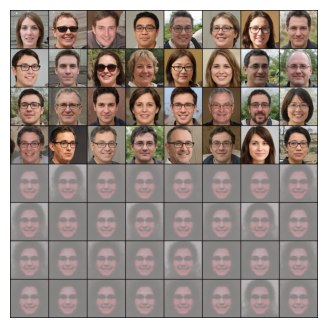

In [32]:
imgs,_=next(iter(loader))
imgs = imgs.to(device)
mu, std, out = vae(imgs)
images=torch.cat([imgs,out],dim=0).detach().cpu()
images = (images + 1.0) / 2.0 
images = torchvision.utils.make_grid(images,8,4)
fig, ax = plt.subplots(figsize=(8,4),dpi=100)
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.axis("off")
plt.show()  

In [91]:
# Downloading model from book for better accuracy 
latent_dims=100
class Encoder(nn.Module):
    def __init__(self, latent_dims=100):  
        super().__init__()
        # input 256 by 256 by 3 channels
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding=1)
        # 128 by 128 with 8 channels
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        # 64 by 64 with 16 channels
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        # 31 by 31 with 32 channels
        self.linear1 = nn.Linear(31*31*32, 1024)
        self.linear2 = nn.Linear(1024, latent_dims)
        self.linear3 = nn.Linear(1024, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() 
        self.N.scale = self.N.scale.cuda()

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        std = torch.exp(self.linear3(x))
        z = mu + std*self.N.sample(mu.shape)
        return mu, std, z 
class Decoder(nn.Module):   
    def __init__(self, latent_dims=100):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 31*31*32),
            nn.ReLU(True))
        self.unflatten = nn.Unflatten(dim=1, 
                  unflattened_size=(32,31,31))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,stride=2,
                               output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2,
                               padding=1, output_padding=1))
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x 
class VAE(nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    def forward(self, x):
        x = x.to(device)
        mu, std, z = self.encoder(x)
        return mu, std, self.decoder(z) 
vae=VAE().to(device)
lr=1e-4 
optimizer=torch.optim.Adam(vae.parameters(),
                           lr=lr,weight_decay=1e-5)

In [92]:
vae.eval()
vae.load_state_dict(torch.load('files/VAEglasses_d.pth',map_location=device))


<All keys matched successfully>

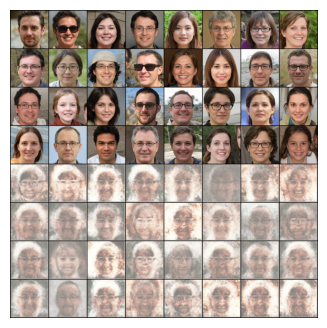

In [93]:
imgs,_=next(iter(loader))
imgs = imgs.to(device)
mu, std, out = vae(imgs)
images=torch.cat([imgs,out],dim=0).detach().cpu()
images = (images + 1.0) / 2.0 
images = torchvision.utils.make_grid(images,8,4)
fig, ax = plt.subplots(figsize=(8,4),dpi=100)
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.axis("off")
plt.show()  

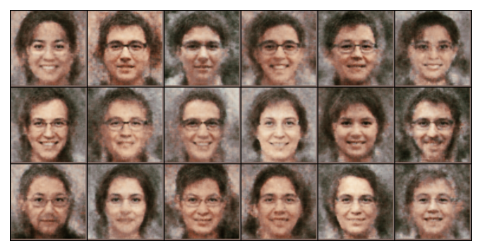

In [94]:
plot_epoch()

# Encoding Arithmetic 

In [107]:
transform = T.Compose([
            T.Resize(256),
            T.ToTensor(),
            ])
data = torchvision.datasets.ImageFolder(
    root="files/glass_data",
    transform=transform)
batch_size=16
loader = torch.utils.data.DataLoader(data,
     batch_size=batch_size,shuffle=True)

latent_dims=100
class Encoder(nn.Module):
    def __init__(self, latent_dims=100):  
        super().__init__()
        # input 256 by 256 by 3 channels
        self.conv1 = nn.Conv2d(3, 8, 3, stride=2, padding=1)
        # 128 by 128 with 8 channels
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        # 64 by 64 with 16 channels
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        # 31 by 31 with 32 channels
        self.linear1 = nn.Linear(31*31*32, 1024)
        self.linear2 = nn.Linear(1024, latent_dims)
        self.linear3 = nn.Linear(1024, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() 
        self.N.scale = self.N.scale.cuda()

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        std = torch.exp(self.linear3(x))
        z = mu + std*self.N.sample(mu.shape)
        return mu, std, z  

class Decoder(nn.Module):   
    def __init__(self, latent_dims=100):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 31*31*32),
            nn.ReLU(True))
        self.unflatten = nn.Unflatten(dim=1, 
                  unflattened_size=(32,31,31))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,stride=2,
                               output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2,
                               padding=1, output_padding=1))
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x  

class VAE(nn.Module):
    def __init__(self, latent_dims=100):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    def forward(self, x):
        x = x.to(device)
        mu, std, z = self.encoder(x)
        return mu, std, self.decoder(z) 
vae=VAE().to(device)
lr=1e-4 
optimizer=torch.optim.Adam(vae.parameters(),
                           lr=lr,weight_decay=1e-5)

import numpy as np
import matplotlib.pyplot as plt

def plot_epoch():
    with torch.no_grad():
        noise = torch.randn(18,latent_dims).to(device)
        imgs = vae.decoder(noise).cpu()
        imgs = torchvision.utils.make_grid(imgs,6,3).numpy()
        fig, ax = plt.subplots(figsize=(6,3),dpi=100)
        plt.imshow(np.transpose(imgs, (1, 2, 0)))
        plt.axis("off")
        plt.show()     

In [108]:
vae.eval()
vae.load_state_dict(torch.load('files/VAEglasses_d.pth',
                              map_location=device))

<All keys matched successfully>

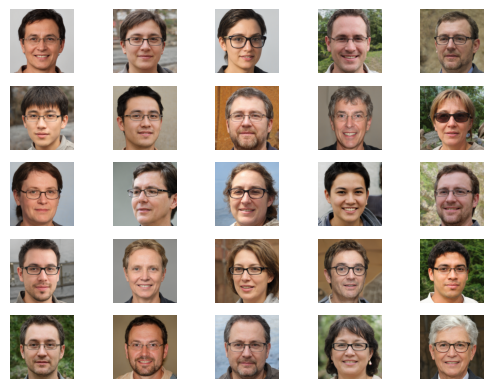

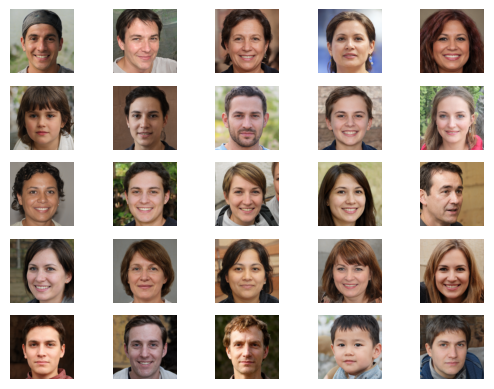

In [111]:
torch.manual_seed(0)  # make sure you fix the random state
glasses=[]
for i in range(25):
    img,label=data[i]
    glasses.append(img)
    plt.subplot(5,5,i+1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.axis("off")
plt.show()
# select three men's images    
men_g=[glasses[0],glasses[4],glasses[14]]
# select three women's images    
women_g=[glasses[9],glasses[17],glasses[23]] 

# collect 25 five images without glasses
noglasses=[]
for i in range(25):
    img,label=data[-i-1]
    noglasses.append(img)
    plt.subplot(5,5,i+1)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.axis("off")
plt.show()
# select three men's images    
men_ng=[noglasses[1],noglasses[7],noglasses[22]]
# select three women's images    
women_ng=[noglasses[4],noglasses[9],noglasses[19]]

In [142]:
men_g_batch = torch.cat((men_g[0].unsqueeze(0),men_g[1].unsqueeze(0),men_g[2].unsqueeze(0)),dim=0).to(device)

In [143]:
_,_,men_g_enc = vae.encoder(men_g_batch)
men_g_enc = men_g_enc.mean(dim=0)
men_g_dec = vae.decoder(men_g_enc.unsqueeze(0))

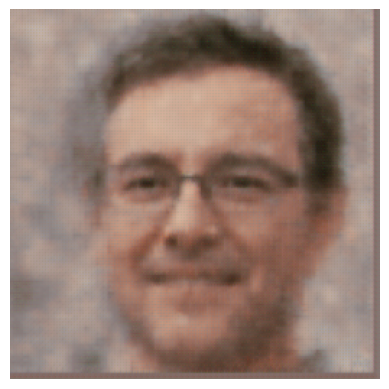

In [144]:
plt.imshow(men_g_dec.squeeze().permute(1,2,0).detach().cpu())
plt.axis("off");

In [145]:
women_g_batch = torch.cat((women_g[0].unsqueeze(0),women_g[1].unsqueeze(0),women_g[2].unsqueeze(0)),dim=0).to(device)

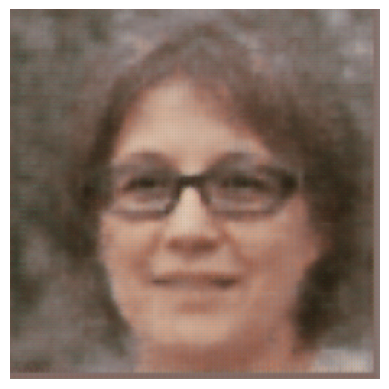

In [146]:
_,_,women_g_enc = vae.encoder(women_g_batch)
women_g_enc = women_g_enc.mean(dim=0)
women_g_dec = vae.decoder(women_g_enc.unsqueeze(0))
plt.imshow(women_g_dec.squeeze().permute(1,2,0).detach().cpu())
plt.axis("off");

In [147]:
men_ng_batch = torch.cat((men_ng[0].unsqueeze(0),men_ng[1].unsqueeze(0),men_ng[2].unsqueeze(0)),dim=0).to(device)

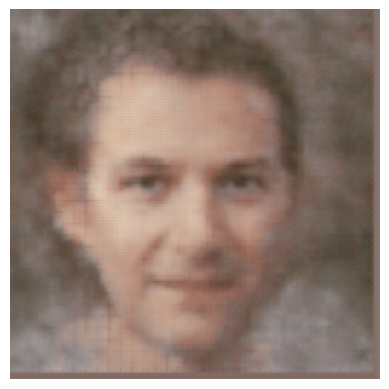

In [148]:
_,_,men_ng_enc = vae.encoder(men_ng_batch)
men_ng_enc = men_ng_enc.mean(dim=0)
men_ng_dec = vae.decoder(men_ng_enc.unsqueeze(0))
plt.imshow(men_ng_dec.squeeze().permute(1,2,0).detach().cpu())
plt.axis("off");

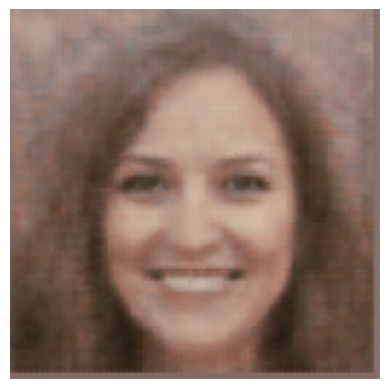

In [149]:
women_ng_batch = torch.cat((women_ng[0].unsqueeze(0),women_ng[1].unsqueeze(0),women_ng[2].unsqueeze(0)),dim=0).to(device)
_,_,women_ng_enc = vae.encoder(women_ng_batch)
women_ng_enc = women_ng_enc.mean(dim=0)
women_ng_dec = vae.decoder(women_ng_enc.unsqueeze(0))
plt.imshow(women_ng_dec.squeeze().permute(1,2,0).detach().cpu())
plt.axis("off");

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

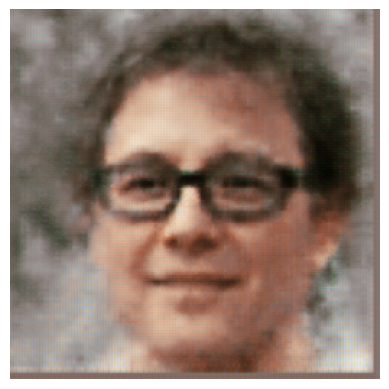

In [152]:
# encoding arthmetic 
## to make a man with glasses 
### so women with glasses - women without glasses + man without glasses 
z = women_g_enc-women_ng_enc+men_g_enc
result = vae.decoder(z.unsqueeze(0))
plt.imshow(result.squeeze().permute(1,2,0).detach().cpu())
plt.axis("off")

(np.float64(-0.5), np.float64(1028.5), np.float64(257.5), np.float64(-0.5))

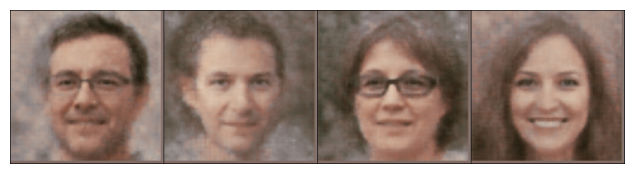

In [153]:
# Available encodings 
encs=torch.cat((men_g_dec,men_ng_dec,women_g_dec,women_ng_dec),dim=0)
imgs = torchvision.utils.make_grid(encs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig,ax=plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.axis("off")

(np.float64(-0.5), np.float64(1028.5), np.float64(257.5), np.float64(-0.5))

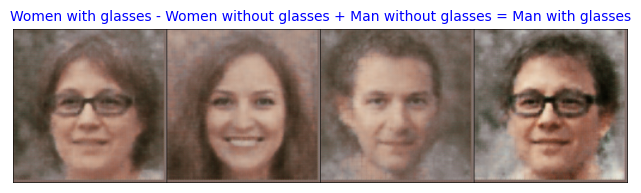

In [157]:
encs=torch.cat((women_g_dec,women_ng_dec,men_ng_dec,result),dim=0)
imgs = torchvision.utils.make_grid(encs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig,ax=plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.title("Women with glasses - Women without glasses + Man without glasses = Man with glasses",fontsize=10,c="b")
plt.axis("off")

(np.float64(-0.5), np.float64(1028.5), np.float64(257.5), np.float64(-0.5))

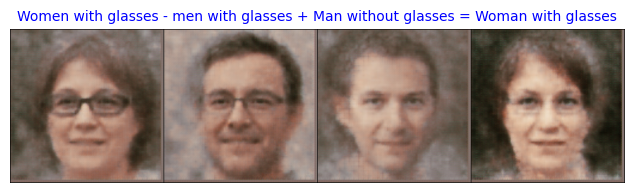

In [160]:
## to make a women without glasses 
### so woman with glasses  - man with glasses - man without glasses
z = women_g_enc+men_ng_enc-men_g_enc
result = vae.decoder(z.unsqueeze(0))
encs=torch.cat((women_g_dec,men_g_dec,men_ng_dec,result),dim=0)
imgs = torchvision.utils.make_grid(encs,4,1).cpu().numpy()
imgs=np.transpose(imgs,(1,2,0))
fig,ax=plt.subplots(figsize=(8,2),dpi=100)
plt.imshow(imgs)
plt.title("Women with glasses - men with glasses + Man without glasses = Woman with glasses",fontsize=10,c="b")
plt.axis("off")

# Image interpolation 